<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Depth_Anything_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depth Anything V1
Paper: https://arxiv.org/pdf/2401.10891.pdf

In [1]:
!gdown 1L3mKl7qlUGE47wZydUST2aTXlBKpN-oI

Downloading...
From: https://drive.google.com/uc?id=1L3mKl7qlUGE47wZydUST2aTXlBKpN-oI
To: /content/img.png
100% 1.55M/1.55M [00:00<00:00, 76.7MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
!pip -q install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.3 MB/s eta 0:00:00


raw input (720, 1280)
raw input (720, 1280) inputs torch.Size([1, 3, 518, 924]) predicted_depth torch.Size([1, 518, 924])
Original model train on the scale of 0 to 30
prediction: min scale = 0.0 max scale= 162.75508


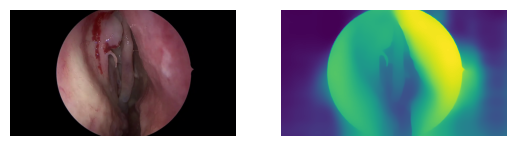

In [6]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
url = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
image = Image.open(url).convert("RGB")

# image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
# model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);
da_v1 = depth

#Depth and Reconstruction

raw input (720, 1280) inputs torch.Size([1, 3, 518, 924]) predicted_depth torch.Size([1, 518, 924])
upsampled predicted_depth: (720, 1280)
Original model train on the scale of 0 to 30
prediction: min scale = -0.008428292 max scale= 162.75526
formatted: min scale = 0 max scale= 255


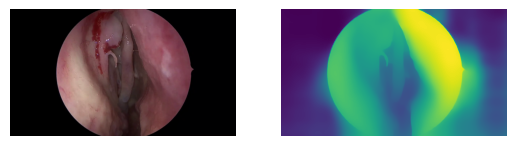

In [60]:
from glob import glob
#imgs_all = glob("/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/*.png")
url = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
image = Image.open(url).convert("RGB")

inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth


print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()

#interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().cpu().numpy()
print('upsampled predicted_depth:', output.shape)

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
print('formatted: min scale =', formatted.min(), 'max scale=', formatted.max())
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);
da_v1 = depth

(720, 1280) -0.008428292 162.75526
(720, 1280) -0.008428292 162.75526


True

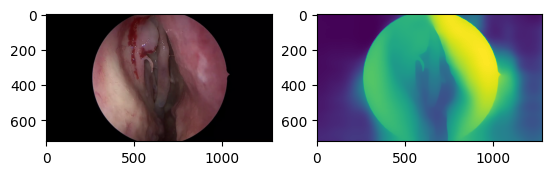

In [61]:
import matplotlib
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2

def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)

def reconstruct_pointcloud(rgb, depth, cam_K, vis_rgbd=False):

    rgb = np.asarray(rgb, order="C")
    rgb_im = o3d.geometry.Image(rgb.astype(np.uint8))
    depth_im = o3d.geometry.Image(depth)

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_im, depth_im, convert_rgb_to_intensity=False)
    if vis_rgbd:
        plt.subplot(1, 2, 1)
        plt.title('RGB image')
        plt.imshow(rgbd_image.color)
        plt.subplot(1, 2, 2)
        plt.title('Depth image')
        plt.imshow(rgbd_image.depth)
        plt.colorbar()
        plt.show()

    cam = o3d.camera.PinholeCameraIntrinsic()
    cam.intrinsic_matrix = cam_K

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        cam
    )

    return pcd


fx = 850.709
img_width =  1280
img_height = 720
intrinsics = np.array([[fx / img_width, 0, 0.5, 0],
                   [0, fx / img_height, 0.5, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

intrinsics[0,:] *= img_width
intrinsics[1,:] *= img_height
cam_K = intrinsics[:3,:3]
vis_pred_depth = render_depth(output/255)
vis_file_name = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086_v2.png"
vis_pred_depth.save(vis_file_name)

pred_depth = output
print(pred_depth.shape, pred_depth.min(), pred_depth.max())
scale = 1 #200
MIN_DEPTH = 1e-3
MAX_DEPTH = 200
pred_depth *= scale
print(pred_depth.shape, pred_depth.min(), pred_depth.max())

pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH
plt.subplot(122); plt.imshow(pred_depth)

img_path = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
img = Image.open(img_path)
img = np.array(img)
plt.subplot(121); plt.imshow(img)

pcd = reconstruct_pointcloud(img, pred_depth, cam_K, vis_rgbd=False)
ply_file_dir = '/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/PLY_DA_Large/0000086_v2.ply'
o3d.io.write_point_cloud(ply_file_dir, pcd)

AttributeError: shape

In [31]:
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
from PIL import Image

# depth.save("/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086.png")

disp_resized_np = output
vmax = np.percentile(disp_resized_np, 95)
normalizer = mpl.colors.Normalize(vmin=disp_resized_np.min(), vmax=vmax)
mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
# print(disp_resized_np[0].shape)
colormapped_im = (mapper.to_rgba(disp_resized_np)[:, :, :3] * 255).astype(np.uint8)
im = Image.fromarray(colormapped_im)
im.save("/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086_v1.png", quality=95)

In [34]:
pred_path = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086_v1.png"
depth_np = cv2.imread(pred_path, 6)[:,:,0]
depth_np.shape, depth_np.min(), depth_np.max()

((720, 1280), 3, 191)

In [37]:
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2

def generate_pointcloud_ply(xyz, color, pc_file):
    # how to generate a pointcloud .ply file using xyz and color
    # xyz    ndarray  3,N  float
    # color  ndarray  3,N  uint8
    df = np.zeros((6, xyz.shape[1]))
    df[0] = xyz[0]
    df[1] = xyz[1]
    df[2] = xyz[2]
    df[3] = color[0]
    df[4] = color[1]
    df[5] = color[2]
    float_formatter = lambda x: "%.4f" % x
    points =[]
    for i in df.T:
        points.append("{} {} {} {} {} {} 0\n".format
                      (float_formatter(i[0]), float_formatter(i[1]), float_formatter(i[2]),
                       int(i[3]), int(i[4]), int(i[5])))
    file = open(pc_file, "w")
    file.write('''ply
    format ascii 1.0
    element vertex %d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    property uchar alpha
    end_header
    %s
    ''' % (len(points), "".join(points)))
    file.close()

# pred_path = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086.png"
# depth_np = cv2.imread(pred_path, 6)
pred_path = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/Depth_DA_Large/0000086_v1.png"
depth_np = cv2.imread(pred_path, 6)[:,:,0]
print(depth_np.shape)

depth = torch.tensor(depth_np, dtype=torch.float32)

img_path = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
img = Image.open(img_path)
img = np.array(img)

print(depth.shape, img.shape)

h, w, _ = img.shape

fx = 850.709
img_width =  1280
img_height = 720
intrinsics = np.array([[fx / img_width, 0, 0.5, 0],
                   [0, fx / img_height, 0.5, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

intrinsics[0,:] *= img_width
intrinsics[1,:] *= img_height

meshgrid = np.meshgrid(range(w), range(h), indexing='xy') #ndarray with shape (h, w),
id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
id_coords = depth.new_tensor(id_coords)# [2, h, w]
pix_coords = torch.cat([id_coords[0].view(-1).unsqueeze(dim=0), id_coords[1].view(-1).unsqueeze(dim=0)], 0)
ones = torch.ones(1, w * h)
pix_coords = torch.cat([pix_coords, ones], dim=0) # 3xHW
inv_K = np.array(np.matrix(intrinsics).I)
inv_K = pix_coords.new_tensor(inv_K)
cam_points = torch.matmul(inv_K[:3, :3], pix_coords)
depth_flatten = depth.view(-1)
cam_points = torch.einsum('cn,n->cn', cam_points, depth_flatten)#[3, 1310720]
img_tensor = torch.tensor(img, dtype=torch.uint8)
img_tensor_flatten = img_tensor.permute(2, 0, 1).flatten(start_dim=1)# [3, 219520]
generate_pointcloud_ply(cam_points, img_tensor_flatten.numpy(), '/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/PLY_DA_Large/0000086_v1.ply')

(720, 1280)
torch.Size([720, 1280]) (720, 1280, 3)


In [36]:
img_path = "/content/drive/MyDrive/Datasets_Weights/Endonasal/real/recon2/imgs/0000086.png"
img = Image.open(img_path)
img = np.array(img)

print(depth.shape, img.shape)

w, h, _ = img.shape

torch.Size([720, 1280]) (720, 1280, 3)


raw input (954, 1110)
raw input (954, 1110) inputs torch.Size([1, 3, 518, 602]) predicted_depth torch.Size([1, 518, 602])
Original model train on the scale of 0 to 30
prediction: min scale = 0.0 max scale= 218.63155


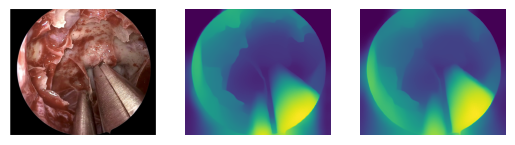

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
image = Image.open(url).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(131),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(132),plt.axis('OFF'),plt.imshow(depth);
plt.subplot(133),plt.axis('OFF'),plt.imshow(da_v1);

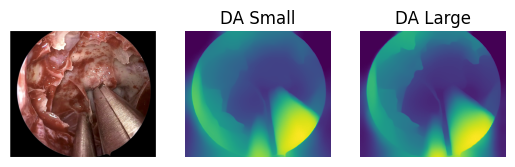

In [ ]:
plt.subplot(131),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(132),plt.axis('OFF'),plt.title('DA Small');plt.imshow(da_v1);
plt.subplot(133),plt.axis('OFF'),plt.title('DA Large');plt.imshow(depth);

raw input (954, 1110)
raw input (954, 1110) inputs torch.Size([1, 3, 518, 602]) predicted_depth torch.Size([1, 518, 602])
Original model train on the scale of 0 to 30
prediction: min scale = 0.6620687 max scale= 6.6914554


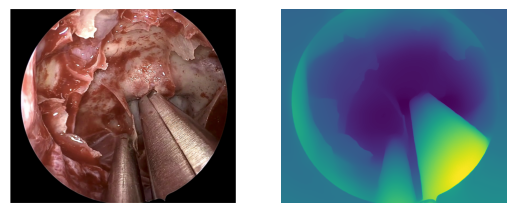

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
image = Image.open(url).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

raw input (954, 1110)
raw input (954, 1110) inputs torch.Size([1, 3, 518, 602]) predicted_depth torch.Size([1, 518, 602])
Original model train on the scale of 0 to 30
prediction: min scale = 28.133162 max scale= 567.1909


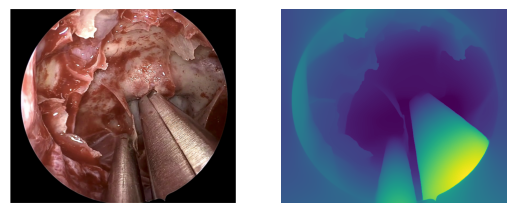

In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, DepthAnythingForDepthEstimation
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "img.png"
image = Image.open(url).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = DepthAnythingForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
print('raw input', image.size[::-1])

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

print('raw input', image.size[::-1],'inputs',inputs['pixel_values'].shape, 'predicted_depth', predicted_depth.shape)
prediction = predicted_depth.clone()
# interpolate to original size
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# )

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

print('Original model train on the scale of 0 to 30')
print('prediction: min scale =', output.min(), 'max scale=', output.max())

#Rescale the reconstruction according to your application
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/np.array(image_processor.image_std)),
                                transforms.Normalize(mean = np.array(image_processor.image_mean)*-1,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(inputs['pixel_values'])
plt.subplot(121),plt.axis('OFF'),plt.imshow(inv_tensor.squeeze().permute(1,2,0))
plt.subplot(122),plt.axis('OFF'),plt.imshow(depth);